In [22]:
import math
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy import fftpack
from scipy.interpolate import CubicSpline
import time
from fastdtw import fastdtw
from collections import Counter
import matplotlib.pyplot as plt

from citylearn.citylearn import CityLearnEnv


colormap=np.array(['blue','#d10a3c','#6f7bbb','#3ac467','#c69942','#FF00FF','#DE9816','#87591A','#D473D4','#54F98D','#B3B191'])

# Function

In [2]:
def ComputeDtw_Matrix(mat,window=1): #Apply DTW to matrix. Return dissimilarity matrix
    res=np.zeros((mat.shape[0],mat.shape[0]))
    nb=res.shape[0]
    
    for i in range(nb):
        for j in range(i):
            res[i,j]=fastdtw(mat[i],mat[j],window)[0]
            
    return (res+res.T)

def ComputeCurveDerivate_Matrix(DF):#retourne la derivee des series temporelles 
    #r=lignes c=colonnes
    r,c=DF.shape
    #matrice nulle de taille r,
    M_derivate=np.zeros((r,len(np.arange(1,c+1))))
    
    for i in range(0,r):
        cs=CubicSpline(np.arange(1,c+1),DF.values[i])
        M_derivate[i]=cs(np.arange(1,c+1),1)#derivee premiere 

    return pd.DataFrame(M_derivate,columns=np.arange(1,c+1),index=DF.index)

def ComputeDerivativeSpectrum_Matrix(DF): #retourne la matrice des spectres
    r,c=DF.shape
    spectre=np.zeros((r,c))
    
    for i,sensor in enumerate(DF.values):
        #Fast Fourier Transfo        
        spectre[i]=abs(np.fft.fft(sensor))
        
    return spectre


def get_indice_individus(clust):#renvoie la position des individus de chaque cluster
    return [list(np.where(clust==elem)[0]) for elem in np.sort(list(Counter(clust)))]

#def get_individus(clust,data):#renvoie les individus composants chaque cluster
#    return [data.iloc[list(np.where(clust==elem)[0])].values for elem in np.sort(list(Counter(clust)))]

def get_individus(clust, data):
    dic={}
    for i,classe in enumerate(clust):
        if str(classe) not in dic.keys():
            dic[str(classe)]=[]
        dic[str(classe)].append(data.index[i])

    return (dic) 
            
def read_conso_from_csv(file,sep='|'):# consommation to dataframe
    elec2=pd.read_csv(file,sep=sep)
    elec2.columns=["date","prm","puissance"]
    dates=list(elec2.date)
    vec=[x.replace(',','.') for x in elec2['puissance']]
    vec=[x.replace(' ','')for x in vec]
    #2018vec=[x.replace(',','')for x in elec2['puissance']]

    elec2.puissance=[float(x) for x in vec]

    prm_unique=list(np.unique(elec2.prm))
    d_unique=list(np.unique(elec2.date))

    #check if there are missing dates
    res=[]

    #ordre de prm
    for elem in prm_unique:
        tmp=elec2[elec2['prm']==elem][['date','puissance']]
        dd={}
        for i,j in tmp.values:
            dd[i]=j
        res.append(dd)
    for i in range(len(res)):
        if len(res[i]) != len(d_unique):
            missing=np.setxor1d(dates,list(res[i].keys()))
            #intersection
            for j in missing:
                res[i][j]=0
    X= pd.DataFrame(res,index=prm_unique)
    X.columns=pd.to_datetime(X.columns)
    return(X)

def read_conso(file,sep='|'):
    cons=pd.read_csv(file,sep=sep,index_col=0)
    cons.columns=pd.to_datetime(cons.columns)
    return cons

#2018
def read_conso2(file,sep=','):
    cons=pd.read_csv(file,sep=sep,index_col=0)
    cons.columns=pd.to_datetime(cons.columns)
    return cons

def apply_clustering(data,k=2,critere="ward",window=1):
    
    #derivee    
    derivees=ComputeCurveDerivate_Matrix(data)

    #Fourier
    spectres=ComputeDerivativeSpectrum_Matrix(derivees)
    
    #spectre2=np.zeros((239, 365))
    #print(spectres.shape)
    ##print(type(spectres))
    
    #spectre2=pd.DataFrame(spectres)
    
    ###print(spectre2)

    #DTW
    dist=ComputeDtw_Matrix(spectres,window)
    #print(dist)
    
    Z=linkage(dist,critere)
    clus=list(fcluster(Z,k,criterion="maxclust"))
    f=fcluster(Z,k,criterion="maxclust")
    
    return clus,Z,f



#colormap=np.array(['blue','#d10a3c','#6f7bbb','#3ac467','#c69942','#FF00FF','#DE9816','#87591A','#D473D4','#54F98D','#B3B191'])
#colormap=np.array(['#B9648A','#16c72e','#1663c7','#c71f16',"#e8e230","#c76f16","#848484","#f49cc8","#e5d1fa","#5c0a33"])
#colormap=np.array(['blue','#d10a3c','#6f7bbb','#3ac467','#c69942'])
                  
class Inerties():#calcul des inerties à partir des partitions
    def __init__(self,clusters):
        self.gi=np.array([e.mean(axis=0) for e in classes])
        self.g=self.gi.mean(axis=0)
        self.clusters=clusters
        
    def inter(self):
        #norm
        res=[len(self.clusters[i])*math.pow(np.linalg.norm(a-self.g),2) for i,a in enumerate(self.gi)]        
        res=np.sum(res)/len(self.gi)
        return res
    
    def total(self):
        cpt=0
        somme=0
        for c in classes:
            for ind in c:
                somme+=math.pow(np.linalg.norm(ind-self.g),2)        
            cpt+=1
        return somme/cpt         
        
    def intra(self):
        return(self.total()-self.inter())
    
def export_toPredict(prmID,DF):
    data=pd.DataFrame({'ds':DF.loc[prmID].index,'y':DF.loc[prmID]})
    data.to_csv("conso_prediction.csv",sep='|',header=True,index=False)
    print("saved in \'conso_prediction.csv\'")
    

# Apply

In [4]:
env = CityLearnEnv(schema='citylearn_challenge_2020_climate_zone_1')

In [38]:
data = pd.DataFrame(columns=range(8760))

for i,e in enumerate(env.buildings):
    data.loc[data.shape[0]+1] = e.energy_simulation.non_shiftable_load

data.head()

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
1,9.89,9.08,8.22,8.57,8.93,9.20,10.35,9.62,12.03,11.13,...,10.55,11.95,10.77,9.92,8.68,9.37,10.13,10.17,9.51,9.48
2,2.36,1.91,2.47,1.80,3.56,6.06,7.49,8.26,10.64,12.37,...,13.15,12.36,14.35,13.20,12.36,11.59,11.51,10.51,5.67,2.39
3,1.65,1.59,1.70,1.79,1.94,2.03,1.91,2.01,1.80,3.94,...,9.95,9.24,9.87,6.69,5.15,1.73,1.74,1.71,1.61,1.87
4,0.46,0.42,0.41,0.43,0.44,0.43,0.45,0.48,0.43,2.68,...,6.90,7.27,7.36,4.92,2.26,2.42,2.35,2.13,2.50,1.57
5,7.50,7.40,7.50,6.20,7.10,8.30,7.80,9.80,16.60,14.60,...,6.10,10.00,7.10,7.20,16.90,14.80,13.60,11.20,13.40,10.80


In [39]:
#days k=2
start=time.time()
cl2,z2,f2=apply_clustering(data,k=3,window=2)
print("temps d'exécution: ",time.time()-start,'s')
classes=get_individus(cl2,data)
print()

temps d'exécution:  55.77515625953674 s



C:\Users\Vincent\AppData\Local\Temp\ipykernel_16360\1575556477.py:113: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z=linkage(dist,critere)


## Visualize clusters

Text(0, 0.5, 'Conso(kwh)')

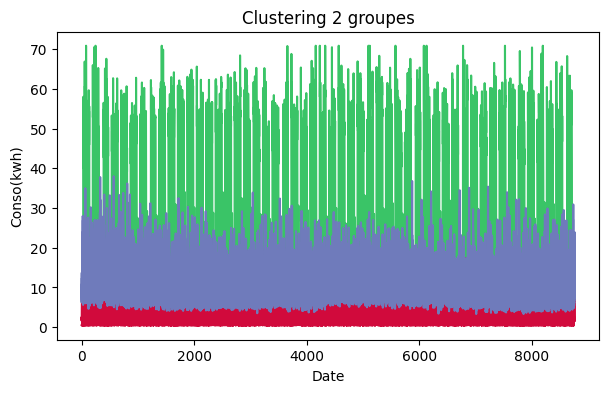

In [40]:
#plot
data.T.plot(legend=False,color=colormap[cl2] ,title='Clustering 3 groupes',figsize=(7,4))
plt.xlabel("Date")
plt.ylabel("Conso(kwh)")

In [42]:
print(classes)

{'3': [1], '1': [2, 3, 4], '2': [5, 6, 7, 8, 9]}
